In [111]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras import layers
from copy import deepcopy

In [112]:
df = pd.read_csv('MSFT.csv')
df

,Date,Open,High,Low,Close,Volume
0,1986-03-13 00:00:00-05:00,0.054485,0.062498,0.054485,0.059827,1031788800
1,1986-03-14 00:00:00-05:00,0.059827,0.063032,0.059827,0.061963,308160000
2,1986-03-17 00:00:00-05:00,0.061963,0.063566,0.061963,0.063032,133171200
3,1986-03-18 00:00:00-05:00,0.063032,0.063566,0.060895,0.061429,67766400
4,1986-03-19 00:00:00-05:00,0.061429,0.061963,0.059827,0.060361,47894400
...,...,...,...,...,...,...
9753,2024-11-22 00:00:00-05:00,411.369995,417.399994,411.059998,417.000000,24814600
9754,2024-11-25 00:00:00-05:00,418.380005,421.079987,414.850006,418.790008,27691100
9755,2024-11-26 00:00:00-05:00,419.589996,429.040008,418.850006,427.989990,23458900
9756,2024-11-27 00:00:00-05:00,425.109985,427.230011,422.019989,422.989990,18332400


In [113]:
df = df[['Date', 'Close']]
df

,Date,Close
0,1986-03-13 00:00:00-05:00,0.059827
1,1986-03-14 00:00:00-05:00,0.061963
2,1986-03-17 00:00:00-05:00,0.063032
3,1986-03-18 00:00:00-05:00,0.061429
4,1986-03-19 00:00:00-05:00,0.060361
...,...,...
9753,2024-11-22 00:00:00-05:00,417.000000
9754,2024-11-25 00:00:00-05:00,418.790008
9755,2024-11-26 00:00:00-05:00,427.989990
9756,2024-11-27 00:00:00-05:00,422.989990


# Preprocessing Data

Avoiding errors by turning the data type of the date to datetime instead of object and also for an easier plotting using matplotlib

In [114]:
def string_to_date(date_string):
    date_part = date_string.split(' ')[0]   
    split = date_part.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)


In [115]:
df['Date'] = df['Date'].apply(string_to_date)
df['Date']

C:\Users\victory tech\AppData\Local\Temp\ipykernel_9788\2012105700.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(string_to_date)


0      1986-03-13
1      1986-03-14
2      1986-03-17
3      1986-03-18
4      1986-03-19
          ...    
9753   2024-11-22
9754   2024-11-25
9755   2024-11-26
9756   2024-11-27
9757   2024-11-29
Name: Date, Length: 9758, dtype: datetime64[ns]

turning the date into the index in order to plot that table on a graph

In [116]:
df.index = df.pop('Date')
df

,Close
Date,
1986-03-13,0.059827
1986-03-14,0.061963
1986-03-17,0.063032
1986-03-18,0.061429
1986-03-19,0.060361
...,...
2024-11-22,417.000000
2024-11-25,418.790008
2024-11-26,427.989990


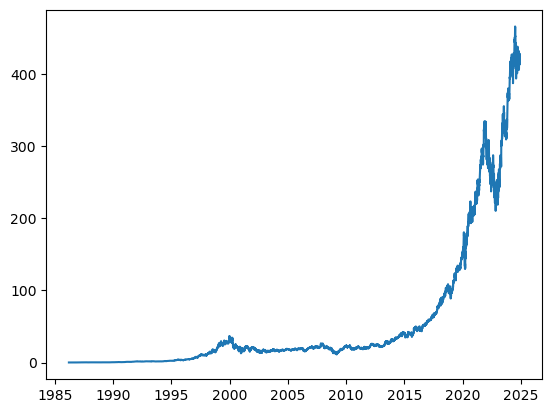

In [117]:
plt.plot(df.index, df['Close'])

Since we're using the LSTM model we'll need to convert this to a supervised learning problem

This will help the model with predicting the next few days or years but taking the 3 previous outputs of the previous days or years and outputting the prediction

In [118]:
def df_to_window(df, first_date, last_date, n=3):
    first_date = string_to_date(first_date)
    last_date = string_to_date(last_date)
    target_date = first_date

    dates = []
    X, Y = [], []
    last_time = False

    while True:
        df_subset = df.loc[:target_date].tail(n+1)
        if len(df_subset) < n + 1:
            print(f'Error, window size {n} is too large for {target_date}')
        
        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]
        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = df.loc[target_date:target_date + datetime.timedelta(days=7)]
        next_datetimeSTR = str(next_week.head(2).tail(1).index.values[0])
        next_dateSTR = next_datetimeSTR.split('T')[0]
        year_month_day = next_dateSTR.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(year=int(year), month=int(month), day=int(day))
        if last_time:
            break
        target_date = next_date

        if target_date == last_date:
            last_time = True
        
    retDF = pd.DataFrame()
    retDF['target date'] = dates
    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        retDF[f'Target - {n-i}'] = X[:, i]
    
    retDF['Target'] = Y
    return retDF

windowDF = df_to_window(df, '2023-11-29', '2024-11-29', n=3)
windowDF

,target date,Target - 3,Target - 2,Target - 1,Target
0,2023-11-29,374.628571,375.799805,379.859467,376.038025
1,2023-11-30,375.799805,379.859467,376.038025,376.097565
2,2023-12-01,379.859467,376.038025,376.097565,371.730255
3,2023-12-04,376.038025,376.097565,371.730255,366.400085
4,2023-12-05,376.097565,371.730255,366.400085,369.755005
...,...,...,...,...,...
248,2024-11-22,416.955414,414.659973,412.869995,417.000000
249,2024-11-25,414.659973,412.869995,417.000000,418.790008
250,2024-11-26,412.869995,417.000000,418.790008,427.989990
251,2024-11-27,417.000000,418.790008,427.989990,422.989990


converting the table into numpy arrays so we can give it directly to a tensorflow model

In [119]:
def windowedDF_to_dateXY(windowDF):
    df_as_np = windowDF.to_numpy()
    dates  = df_as_np[:, 0]
    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1] , 1))
    Y = df_as_np[:, -1]
    return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, Y = windowedDF_to_dateXY(windowDF)
dates.shape, X.shape, Y.shape

((253,), (253, 3, 1), (253,))

splitting data into train, test, and validation

In [120]:
first = int(len(dates) * 0.8)
second = int(len(dates) * 0.9)
dates_train, X_train, Y_train = dates[:first], X[:first], Y[:first]
dates_val, X_val, Y_val = dates[first:second], X[first:second], Y[first:second]
dates_test, X_test, Y_test = dates[second:], X[second:], Y[second:]

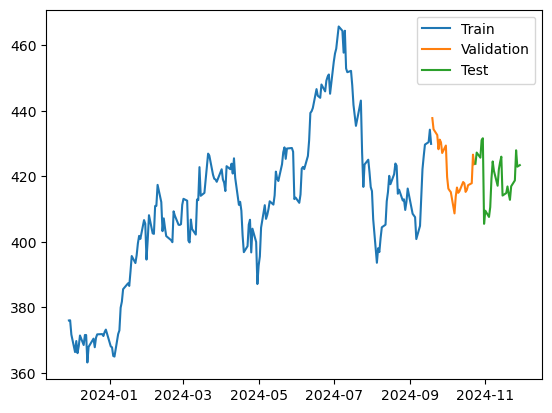

In [121]:
plt.plot(dates_train, Y_train, label='Train')
plt.plot(dates_val, Y_val, label='Validation')
plt.plot(dates_test, Y_test, label='Test')
plt.legend()

# Creating the model

Start off by specifying the shape of the input by sorting out the layers, 64 since its more prone to overfitting and can handle heavy duty

In [122]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1),])

Since this is a regression problem we use metrics such as MSE (Mean Squared Error) and MAE (Mean Absolute Error)

MSE is used to calculate the average squared differences between the predicted value and the actual value with outliers in mind.

MAE is used to calculate the average absolute difference between predicted and actual values but it's more robust to outliers and doesnt punish for them.

In [123]:
model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mae'])
model.fit(X_train, Y_train, epochs=200, batch_size=32, validation_data=(X_val, Y_val))

Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 168678.1562 - mae: 410.0684 - val_loss: 177637.9375 - val_mae: 421.4022
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 169567.4062 - mae: 411.1787 - val_loss: 177248.7031 - val_mae: 420.9400
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 168427.7500 - mae: 409.7415 - val_loss: 176762.0625 - val_mae: 420.3616
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 168888.2188 - mae: 410.3085 - val_loss: 176162.8594 - val_mae: 419.6483
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 168518.4062 - mae: 409.8049 - val_loss: 175401.0781 - val_mae: 418.7397
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 168114.7031 - mae: 409.3849 - val_loss: 174324.1406 - val_mae: 417.4517
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 166304.5625 - mae: 407.1051 - val_loss: 173045.5156 - val_mae: 415.9175
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 163693.1250 - mae: 403.9187 - val_loss:

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


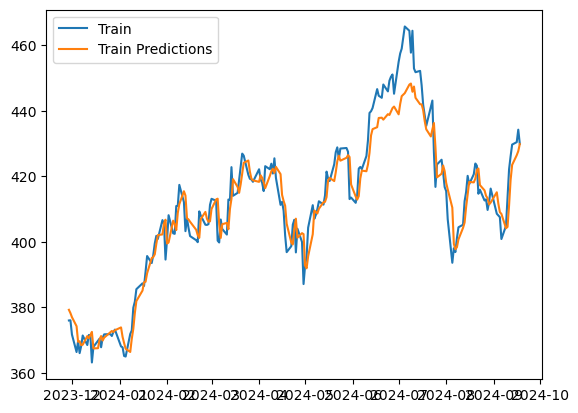

In [124]:
train_predictions = model.predict(X_train).flatten()
plt.plot(dates_train, Y_train, label='Train')
plt.plot(dates_train, train_predictions, label='Train Predictions')
plt.legend()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


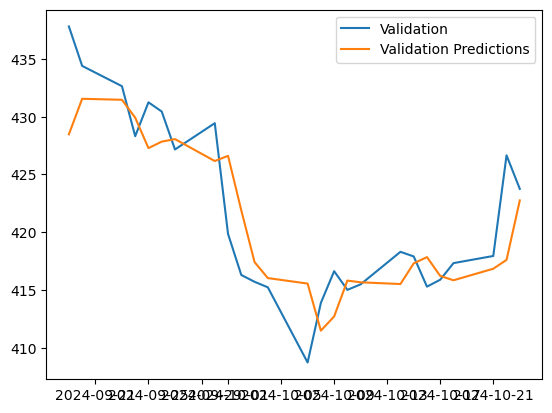

In [125]:
val_predictions = model.predict(X_val).flatten()
plt.plot(dates_val, Y_val, label='Validation')
plt.plot(dates_val, val_predictions, label='Validation Predictions')
plt.legend()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


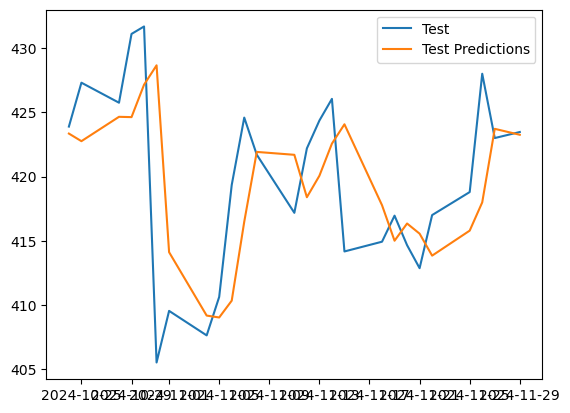

In [126]:
test_predictions = model.predict(X_test).flatten()
plt.plot(dates_test, Y_test, label='Test')
plt.plot(dates_test, test_predictions, label='Test Predictions')
plt.legend()

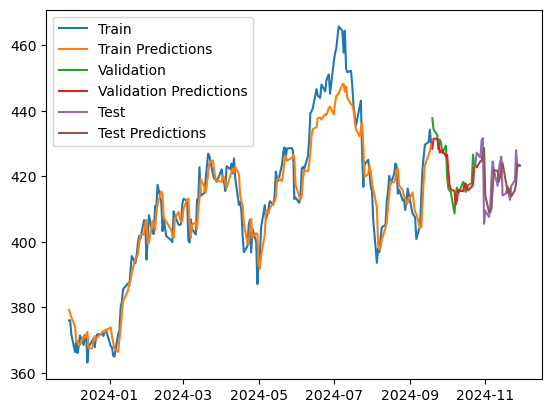

In [127]:
plt.plot(dates_train, Y_train, label='Train')
plt.plot(dates_train, train_predictions, label='Train Predictions')
plt.plot(dates_val, Y_val, label='Validation')
plt.plot(dates_val, val_predictions, label='Validation Predictions')
plt.plot(dates_test, Y_test, label='Test')
plt.plot(dates_test, test_predictions, label='Test Predictions')
plt.legend()

making the model predict the upcoming increase or decrease

In [128]:
recursive_predictions = []
recursive_dates = np.concatenate((dates_val, dates_test))

In [129]:
for target_date in recursive_dates:
    last_window = deepcopy(X_train[-1])
    next_prediction = model.predict(np.array([last_window])).flatten()[0]
    recursive_predictions.append(next_prediction)
    last_window[-1] = next_prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━

The dotted line is how much the model predicts the stock to increase.

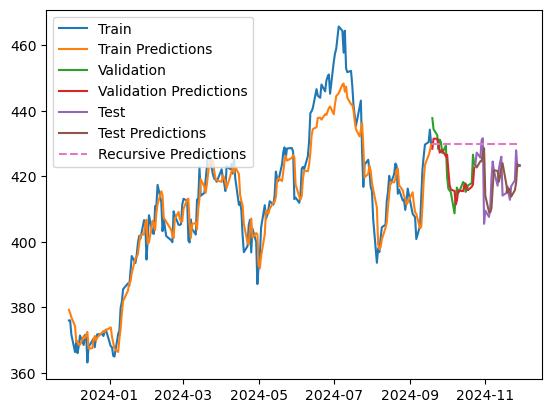

In [133]:
plt.plot(dates_train, Y_train, label='Train')
plt.plot(dates_train, train_predictions, label='Train Predictions')
plt.plot(dates_val, Y_val, label='Validation')
plt.plot(dates_val, val_predictions, label='Validation Predictions')
plt.plot(dates_test, Y_test, label='Test')
plt.plot(dates_test, test_predictions, label='Test Predictions')
plt.plot(recursive_dates, recursive_predictions, label='Recursive Predictions', linestyle='--')
plt.legend()